## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [87]:
import json
import numpy as np
import pandas as pd

import re, nltk, spacy, string
nlp = spacy.load('en_core_web_sm')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from collections import Counter

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

#Time
import time
from datetime import datetime

import pickle

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



## Optional - Mount drive and download data for Colab

In [88]:
#'''
import glob
import os
import shutil
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive',force_remount=True)
# Define the path where you want to save the data in your Google Drive
folder_path = '/content/drive/My Drive/Ticket_Classification'
#'''

Mounted at /content/drive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [89]:
# Opening JSON file
data_path=f'{folder_path}/complaints-2021-05-14_08_16.json'
f = open(data_path,'r', encoding="utf-8")# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

In [90]:
'''
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json','r', encoding="utf-8")# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)
'''

'\n# Opening JSON file\nf = open(\'complaints-2021-05-14_08_16.json\',\'r\', encoding="utf-8")# Write the path to your data file and load it\n\n# returns JSON object as\n# a dictionary\ndata = json.load(f)\ndf=pd.json_normalize(data)\n'

## Data preparation

In [91]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [92]:
#print the column names
print(f'Column names : {list(df.columns)}')

Column names : ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [93]:
#Check and identify pattern
pattern1=r'^_source.'
cleaned_columns=[re.sub(pattern1,'',column) for column in df.columns ]
print(cleaned_columns)
#Check and identify pattern
pattern2=r'^_'
cleaned_columns=[re.sub(pattern2,'',column) for column in cleaned_columns ]
print(cleaned_columns)

['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']
['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [94]:
#Assign new column names
df.columns=cleaned_columns
df.head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided


In [95]:
print(f'Count of null values {df["complaint_what_happened"].isnull().sum()}')
print('Count of empty values' , (df["complaint_what_happened"]=='').sum())

Count of null values 0
Count of empty values 57241


In [96]:
df[df["complaint_what_happened"]==''].head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided


In [97]:
#Assign nan in place of blanks in the complaints column
df["complaint_what_happened"]=df["complaint_what_happened"].replace('',np.nan)
df.head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided


In [98]:
#Remove all rows where complaints column is nan
df=df[~ df["complaint_what_happened"].isnull() ]
df.reset_index(drop=True, inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",Information belongs to someone 

### Check length of chars in complaint columns

In [99]:
df["complaint_what_happened"].str.len().describe([0.10,0.20,0.25,0.50,0.75,0.90,0.95,0.97,0.99])

,complaint_what_happened
count,21072.000000
mean,1384.006312
std,1502.196518
min,19.000000
10%,283.000000
20%,450.000000
25%,528.000000
50%,983.000000
75%,1738.000000
90%,2922.900000


#### Check columns having less chars

In [100]:
df[df["complaint_what_happened"].str.len()<20]["complaint_what_happened"]

,complaint_what_happened
5799,inquiry not removed
8697,Chase will not help


#### Check columns having more chars

In [101]:
df[df["complaint_what_happened"].str.len()>6915]["complaint_what_happened"]

39                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [102]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text,test=False):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    if test:
        print(f'Original Text:\n{"-"*100}\n{text}\n{"="*100}')
    # Make text lowercase
    cleaned_text=text.lower()
    if test:
        print(f'After lowercase:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    # Remove text in square brackets
    pattern=r'\[*?\]'
    cleaned_text=re.sub(pattern,'',cleaned_text)
    if test:
        print(f'After removing square brackets:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    # Remove punctuation
    pattern=r'[%s]' % re.escape(string.punctuation)
    cleaned_text=re.sub(pattern,'',cleaned_text)
    if test:
        print(f'After removing punctuation:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    # Remove words containing numbers
    pattern=r'\w*\d\w*'
    cleaned_text=re.sub(pattern,'',cleaned_text)
    if test:
        print(f'After removing words containing numbers:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    return cleaned_text

In [103]:
#Write your function to Lemmatize the texts
def lema_text(text, test=False):
    '''Lemmatize the texts.'''
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    lema_text=" ".join(sent)
    if test:
        print(f'After Lemmatization:\n{"-"*100}\n{lema_text}\n{"="*100}')
    return lema_text

In [104]:
string_test=df.loc[1,"complaint_what_happened"]
string_test_cleaned=clean_text(string_test,test=True)

Original Text:
----------------------------------------------------------------------------------------------------
I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.
After lowercase:
----------------------------------------------------------------------------------------------------
i upgraded my xxxx xxxx card in xx/xx/2018 and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.
After removing square brackets:
----------------------

In [105]:
# Efficient bulk processing using spaCy pipe
def lemmatize_texts(texts, test=False):
    """Lemmatize a list of texts."""
    stopwords = nlp.Defaults.stop_words
    if test:
        print(f'Original Text:\n{"-"*100}\n{texts}\n{"="*100}')
    lemmatized = []
    for doc in nlp.pipe(texts, batch_size=1000, disable=["parser", "ner"]):
        lemmatized.append(" ".join([ token.lemma_ for token in doc if token.text not in set(stopwords) ]))
    if test:
        print(f'After Lemmatization:\n{"-"*100}\n{lemmatized}\n{"="*100}')
    return lemmatized

In [106]:
string_test_lema=lemmatize_texts([string_test_cleaned],test=True)

Original Text:
----------------------------------------------------------------------------------------------------
['i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me']
After Lemmatization:
----------------------------------------------------------------------------------------------------
['upgrade xxxx xxxx card   tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx    change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead']


In [107]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaint_what_happened']]
print(df_clean.shape)

(21072, 1)


In [108]:
# Clean data
df_clean = df_clean.copy()
df_clean.loc[:,'complaint_what_happened_lemmatized']=df_clean['complaint_what_happened'].apply(lambda x: clean_text(x))

In [109]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then imm

In [110]:
# Apply lemmatization
df_clean = df_clean.copy()
df_clean.loc[:,'complaint_what_happened_lemmatized'] = lemmatize_texts(df_clean['complaint_what_happened_lemmatized'])

In [111]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer get apply account statement purchase ticket explicitly tell glad get deny absolutely long interested account ask application withdraw representative oblige happen later put application notwithstanding explicit request proceed application contrary tell chase representative chase fact ahead open credit account report credit report chase refuse correct information credit report go ahead process

In [112]:
#Write your function to extract the POS tags

def pos_tag(text, test=False):
    """Extract singular nouns (NN) from text using POS tagging."""
    pos_tags = []
    # Wrap the input text in a list to use `nlp.pipe`
    for doc in nlp.pipe([text], disable=["parser", "ner"]):
        for token in doc:
            if token.tag_ == "NN":  # Check if the token is a singular noun
                pos_tags.append(token.text)

    pos_tags_filtered = " ".join(pos_tags)

    if test:
        print(f'Before POS removed:\n{"-"*100}\n{text}\n{"="*100}')
        print(f'After POS removed:\n{"-"*100}\n{pos_tags_filtered}\n{"="*100}')

    return pos_tags_filtered

In [113]:
string_test=df_clean.loc[1,"complaint_what_happened_lemmatized"]
string_test_POS_removed=pos_tag(string_test,test=True)

Before POS removed:
----------------------------------------------------------------------------------------------------
upgrade xxxx xxxx card   tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx    change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead
After POS removed:
----------------------------------------------------------------------------------------------------
card agent upgrade anniversary date change agent information order account anniversary date agent


In [114]:
df_clean = df_clean.copy()
# This column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"]
df_clean.loc[:,'complaint_POS_removed'] = df_clean['complaint_what_happened_lemmatized'].apply(lambda x: pos_tag(x))

In [115]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer get apply account statem

In [116]:
#'''
import glob
import os
import shutil
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive',force_remount=True)
# Define the path where you want to save the data in your Google Drive
consolidated_folder = f'{folder_path}/file'
# Path to the CSV file you want to copy
df_clean.to_csv('df_clean.csv')
source_file = '/content/df_clean.csv'
# Step 1: Check if the consolidated folder exists
if os.path.exists(consolidated_folder):
    # If it exists, delete the folder and its contents
    shutil.rmtree(consolidated_folder)
    print(f"{consolidated_folder} folder has been deleted.")
else:
    print(f"{consolidated_folder} folder does not exist.")
# Create the consolidated folder
os.makedirs(consolidated_folder, exist_ok=True)
# Step 2: Copy the file to the consolidated destination
shutil.copy(source_file, os.path.join(consolidated_folder, os.path.basename(source_file)))
print(f"File {source_file} has been copied to {consolidated_folder}.")
#'''

Mounted at /content/drive
/content/drive/My Drive/Ticket_Classification/file folder has been deleted.
File /content/df_clean.csv has been copied to /content/drive/My Drive/Ticket_Classification/file.


In [117]:
df_clean=pd.read_csv('df_clean.csv')
df_clean.drop(columns=['Unnamed: 0'],inplace=True)
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer get apply account statem

In [118]:
df_clean[df_clean["complaint_POS_removed"].isnull()]

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
58,ChaseMortgagehasautomaticallydeducted2mortgagepaymentsfrommyXXXXXXXXcheckingaccountwithoutmypermission.Iamnotsetupuponautomaticpayments.IdidnotauthorizethemtodeductandIamcurrentonmyloan.,NaN,NaN
1487,Please forward the information to J.P Morgan Chase Bank. Thanks!,forward information jp morgan chase bank thank,NaN
1619,Did not inquire this,inquire,NaN
1931,I keep getting billed for lock box with chase I never had one and don't have one now,get bill lock box chase not,NaN
2813,"IreceivedanemailXX/XX/XXXXthatmycreditcardswereclosedimmediately.ThatisinviolationwithCIVILCODE-CIVDIVISION3.OBLIGATIONS[1427-3273](HeadingofDivision3amendedbyStats.1988,Ch.160,Sec.14.)PART4.OBLIGATIONSARISINGFROMPARTICULARTRANSACTIONS[1738-3273](Part4enacted1872.)TITLE1.3.CREDITCARDS[1747-1748.95](Title1.3addedbyStats.1971,Ch.1019.)1747.85.\nUnlessrequestedbythecardholder,nocardissuershallcancelacreditcardwithouthavingfirstgiventhecardholder30dayswrittennoticeofitsintentiontodosounlessthecardholderisorhasbeenwithinthelast90daysindefaultofpaymentorotherwiseinviolationofanyprovisionoftheagreementbetweenthecardissuerandthecardholdergoverningthecardholdersuseofthecreditcardorunlessthecardissuerhasevidenceorreasonablebeliefthatthecardholderisunableorunwillingtorepayobligationsincurredundertheagreementorthatanunauthorizeduseofthecardmaybemade.\nNothingprovidedhereinshallbeconstruedtoprohibitacardissuerfromplacingtheaccountofacardholderoninactivestatusifthecardholderhasnotusedthecardforaperiodinexcessof18monthsorfromrequiringthatcardholder,uponsubsequentreuseofacard,toprovidetothecardissuersuchupdatedinformationaswillenablethecardissuertoverifythecurrentcreditworthinessofthecardholder.\n\n\nThereasonschasebackclosedmyaccountswerestatedasToomanyaccountsopenedrecentlyToomanyrequestsforcreditorreviewsofcreditNowthosereasonsthattheyclosedmyaccountsarenotstatedinthecardmemberagreements.Andthefactthattheywrittenandclosedmyaccountsthesamedayisaclearviolationofthemgivingmeawritten30daynoticeoftheirintenttodoso.Thisisaclearproblem.Iwillbegoingafterarbitrationforthismishandlingofmyaccounts.",\n\n\n\n\n,NaN
3194,IacceptedapromotionalofferonmyChaseSapphirecreditcard.Theofferwasfor15%creditbackifIusedmySapphirecreditcardonXXXXbyXX/XX/19.IbookedmyreservationonmySapphirecardandthetransactionfor{$840.00}postedonXX/XX/19.Icalledtofindoutwhenthecreditwouldpostandwastolditwouldtakeseveralbusinessdaysforthecredittopost.Icalledbackagainandadifferentrepresentativetoldmeitwouldtakeupto14businessdaystopost.Icalledafterthe14businessdayandtherepresentativeconfirmedImetthecriteriafortheofferandopenedanescalationticket.SheadvisedIcallbackin2-3businessdaystogetthefinalresolution.Icalledbackwithinthattimeframeandwastoldescalationtakeupto7businessdays.IcalledbackattheendoftheXX/XX/XXXXbusinessday(XX/XX/0219)andwastoldbytherepresentativetheescalationcouldtakeupto4weeks.Irequestedtospeakwithasupervisor.Thesupervisorstatedtheescalationshouldhavebeencompletedwithin7businessdays.Hecouldnotprovidemewitharesolutionand/ortimeframeforresolution.HecouldnottransfermetotheExecutiveofficeforfurtherreview.IcalledonXX/XX/19tospeakwiththeExecutiveOfficebutwastransferredmultipletimesandwasunsuccessfulinreachingtheExecutiveOffice.,NaN,NaN
4988,"Throughoutthelastfewmonthswehavehadawebsite(XXXX)withdrawanddepositlargeamountsofmoneyintoourbusinessChaseBankingaccount.Wehaveattemptedtoresolvethisissuewiththebank,withlittleluckorinformationgiventous.Thechargesbeganwitha""test""onXX/XX/2018XXXXdepositedXXXXintoouraccountandthenanotherdepositofXXXX.Twodayslater,XX/XX/2018,XXXXwithdrew$XXXXand$XXXXintwoseparatetransactions,thenXX/XX/2018theywithdrew$XXXX.AgainonXX/XX/2018theywithdrew$XXXX.AtthistimeweapproachedthebankandwerecreditedonXX/XX/2018,theamountsof$XXXX&$XXXXintoouraccount,onXX/XX/2018thedeposited$XXXX.(WeareunclearifthisCREDITwasmadebyChasebankorthewebsite)XX/XX/2018theChaseBankreturnedthefundstoouraccountonlytohave$XXXXbea

In [119]:
#Remove all rows where complaints column is nan
df_clean=df_clean[~ df_clean["complaint_POS_removed"].isnull() ]
df_clean.reset_index(drop=True, inplace=True)

In [120]:
df_clean[df_clean["complaint_POS_removed"].isnull()]

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




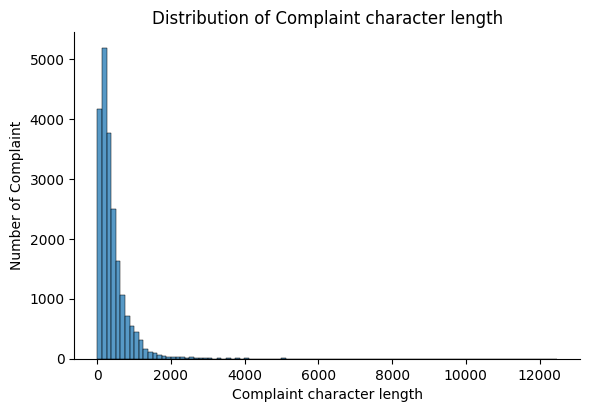

In [121]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_lens=df_clean["complaint_POS_removed"].str.len()
sns.displot(complaint_lens,bins=100,height=4, aspect=1.5)
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [122]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean = df_clean.copy()
df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['complaint_what_happened_lemmatized_length'] = df_clean['complaint_what_happened_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()


fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint Length'))
fig.add_trace(go.Histogram(x=df_clean['complaint_what_happened_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

In [123]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

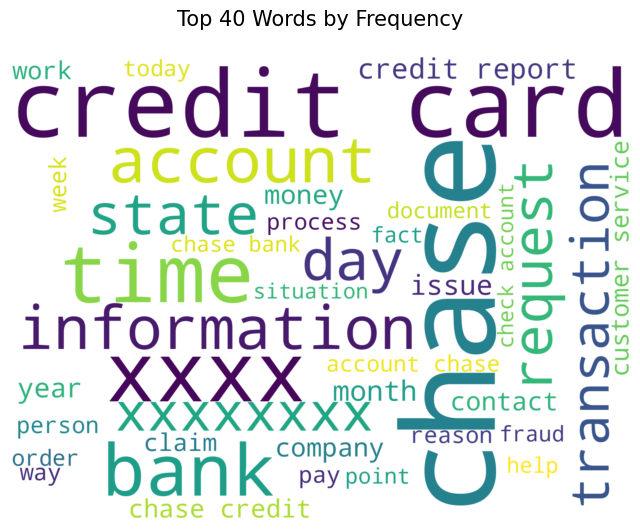

In [124]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stopwords = nlp.Defaults.stop_words
wordcloud=WordCloud(stopwords= stopwords, background_color='white', width=2000, height=1500, max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
# Display the Word Cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.title("Top 40 Words by Frequency\n", fontsize=15)
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [125]:
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [126]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
unigram = get_top_n_words(df_clean['complaint_clean'], 1,30)
words_freq_df = pd.DataFrame(unigram, columns = ['unigram' , 'unigram_freq'])
px.bar(x=words_freq_df['unigram'], y=words_freq_df['unigram_freq'], title='Top 30 Unigrams')

In [127]:
#Print the top 10 words in the unigram frequency
words_freq_df.head(10)

,unigram,unigram_freq
0,chase,54043
1,account,41339
2,credit,33612
3,xxxx,33326
4,card,29904
5,payment,21108
6,bank,17559
7,time,15919
8,charge,15350
9,day,12913


In [128]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram = get_top_n_words(df_clean['complaint_clean'], 2,30)
words_freq_df['bigram'] = [word for word, freq in bigram]
words_freq_df['bigram_freq'] = [freq for word, freq in bigram]
px.bar(x=words_freq_df['bigram'], y=words_freq_df['bigram_freq'], title='Top 30 Bigrams')

In [129]:
#Print the top 10 words in the bigram frequency
words_freq_df.head(10)

,unigram,unigram_freq,bigram,bigram_freq
0,chase,54043,credit card,12789
1,account,41339,credit report,3904
2,credit,33612,chase credit,3085
3,xxxx,33326,customer service,2931
4,card,29904,account chase,2470
5,payment,21108,chase bank,2185
6,bank,17559,check account,2143
7,time,15919,xxxx xxxx,2117
8,charge,15350,chase account,2045
9,day,12913,contact chase,1926


In [130]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram = get_top_n_words(df_clean['complaint_clean'], 3,30)
words_freq_df['trigram'] = [word for word, freq in trigram]
words_freq_df['trigram_freq'] = [freq for word, freq in trigram]
px.bar(x=words_freq_df['trigram'], y=words_freq_df['trigram_freq'], title='Top 30 Trigram')

In [131]:
#Print the top 10 words in the trigram frequency
words_freq_df.head(10)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq
0,chase,54043,credit card,12789,chase credit card,2211
1,account,41339,credit report,3904,credit card account,1051
2,credit,33612,chase credit,3085,credit card company,977
3,xxxx,33326,customer service,2931,credit card chase,747
4,card,29904,account chase,2470,xxxx credit card,679
5,payment,21108,chase bank,2185,chase customer service,563
6,bank,17559,check account,2143,inquiry credit report,486
7,time,15919,xxxx xxxx,2117,credit card credit,431
8,charge,15350,chase account,2045,credit card xxxx,414
9,day,12913,contact chase,1926,charge credit card,406


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [132]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [133]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,300,147,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent,355,210,97,card agent upgrade anniversary date change agent information order account anniversary date agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,224,134,101,chase card report application submit identity consent service extend credit verify identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this info

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [134]:
#Write your code here to initialise the TfidfVectorizer
tf_idf_vec = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [135]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf=tf_idf_vec.fit_transform(df_clean['complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [136]:
from sklearn.decomposition import NMF

## Coherence Model to select best number of Topics
With the Coherence Model we will see how to automatically select the best number of topics.


In [137]:
'''
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_clean']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )

    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)
'''

'\nimport warnings\nwarnings.filterwarnings("ignore")\nfrom gensim.corpora.dictionary import Dictionary\nfrom gensim.models.nmf import Nmf\nfrom gensim.models.coherencemodel import CoherenceModel\nfrom operator import itemgetter\n# Use Gensim\'s NMF to get the best num of topics via coherence score\ntexts = df_clean[\'complaint_clean\']\ndataset = [d.split() for d in texts]\n\n# Create a dictionary\n# In gensim a dictionary is a mapping between words and their integer id\ndictionary = Dictionary(dataset)\n\n# Filter out extremes to limit the number of features\ndictionary.filter_extremes(\n    no_below=3,\n    no_above=0.85,\n    keep_n=5000\n)\n\n# Create the bag-of-words format (list of (token_id, token_count))\ncorpus = [dictionary.doc2bow(text) for text in dataset]\n\n# Create a list of the topic numbers we want to try\ntopic_nums = list(np.arange(5, 10, 1))\n\n# Run the nmf model and calculate the coherence score\n# for each number of topics\ncoherence_scores = []\n\nfor num in to

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [138]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [139]:
nmf_model.fit(tfidf)
len(tf_idf_vec.get_feature_names_out())

6507

In [140]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['claim', 'customer', 'transaction', 'business', 'number', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'bank', 'money', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['time', 'reason', 'service', 'application', 'month', 'point', 'purchase', 'year', 'limit', 'score', 'account', 'balance', 'chase', 'credit', 'card']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['date', 'statement', 'property', 'balance', 'rate', 'year', 'pay', 'time', 'home', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['letter', 'score', 'dispute', 'theft', 'remove', 'file', 'identity', 'account', 'reporting', 'debt', 'information', 'company', 'credit', 'inquiry', 'report']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['statement', 'time', 'contact', 'email', 'service', 'fraud', 'refund', 'purchase', 'claim', 'merchant', 'transaction', 'chase', 'fee', 'disp

In [141]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)

array([0, 1, 3, ..., 3, 1, 2])

In [142]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1)#write your code to assign topics to each rows.

In [143]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,300,147,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent,355,210,97,card agent upgrade anniversary date change agent information order account anniversary date agent,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,224,134,101,chase card report application submit identity consent service extend credit verify identity applicant,3
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to corre

In [144]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values(by='Topic')

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,300,147,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
10,mishandling of this account by Chase auto and XXXX.,mishandle account chase auto xxxx,mishandle account chase auto xxxx,51,33,33,mishandle account chase auto,0
6,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day. That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday, XX/XX/2019. Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement. Ive been called and I was told that it may take two business day stating Tuesday, XX/XX/XXXX would be the date that my funds would be available to withdraw from a bank teller only. Now, Chase is informing me that I will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. Unfortunately, This has put me in an additional financial bind do two fees from late rent late car payments, etc. I am not being a short or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. I am not being a shored or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. This situation is truly affecting my livelihood and they dont seem to want to deal with Me professionally. Thank you",notice jp morgan chase restrict account debit card tuesday thursday go branch advise customer service representative account actually close go branch remove fund currently direct deposit place employment return bank associate customer service representative assure

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [145]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic_category'] = df_clean['Topic'].map(Topic_names)

In [146]:
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean,Topic,Topic_category
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,300,147,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0,Bank Account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent,355,210,97,card agent upgrade anniversary date change agent information order account anniversary date agent,1,Credit card or prepaid card
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,224,134,101,chase card report application submit identity consent service extend credit verify identity applicant,3,Theft/Dispute Reporting
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on 

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [147]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [148]:
training_data

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",3
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",3
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,0
...,...,...
21054,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for acquiring new credit cards with Chase - all with bonus airline miles and hotel points. Was approved for all ( 3 ) new cards with No annual fee for 1st year. After less than 2 months with payment always paid as agreed, Chase closed all my cards. One of my ( 3 ) approved new cards was never activated but was sent to me.\n\nChase has done harm to my credit, has charged me an annual fee even though they cancelled my account, failed to credit my points for both airlines and hotel, failed to credit up to {$100.00} for XXXX enrollment and failed to credit airline charge as agreed upon",1
21055,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to make a claim under their purchase protection benefit. On XX/XX/XXXX, I purchased three hig

In [149]:
training_data['Topic'].value_counts()

,count
Topic,
0,5194
2,5102
4,4444
1,3962
3,2357


In [150]:
# Checking for class imbalance
px.bar(x=training_data['Topic'].value_counts().index, y=training_data['Topic'].value_counts().values/max(training_data['Topic'].value_counts().values), title='Class Imbalance')

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [151]:
#GET VECTOR COUNT
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

#SAVE WORD VECTOR
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [152]:
#TRANSFORM WORD VECTOR TO TF IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#SAVE TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [153]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

In [154]:
# Prepare the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.2, random_state=40)

### Custom functions

In [155]:
def evaluate_model( X_true, y_true, estimator, data_name, dataset_type, cut_off=0.5 ):
    print(f"Evaluating {dataset_type} Set: data set name - {data_name}")
    # Prediction
    y_pred = estimator.predict(X_true)
    y_pred_prob = estimator.predict_proba(X_true)[:, 1]
    if cut_off!=0.5 :
        # Binarize predictions based on the cutoff
        y_pred = [1 if prob >= cut_off else 0 for prob in y_pred_prob]
    # Confusion matrix
    confusion = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", confusion)
    # Classification report
    classification = classification_report(y_true, y_pred)
    print("\nClassification Report:\n", classification)
    # Extract TP, TN, FP, FN
    TP = confusion[1, 1]  # True Positive
    TN = confusion[0, 0]  # True Negative
    FP = confusion[0, 1]  # False Positive
    FN = confusion[1, 0]  # False Negative
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {round(100 * accuracy, 2)}%")
    # Sensitivity (Recall for the positive class)
    sensitivity = TP / float(TP + FN) if (TP + FN) > 0 else 0
    print(f"Sensitivity: {round(100 * sensitivity, 2)}%")
    # Specificity (Recall for the negative class)
    specificity = TN / float(TN + FP) if (TN + FP) > 0 else 0
    print(f"Specificity: {round(100 * specificity, 2)}%")
    # Precision
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {round(100 * precision, 2)}%")
    # Recall
    recall = recall_score(y_true, y_pred)
    print(f"Recall: {round(100 * recall, 2)}%")
    # ROC AUC score
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    print(f"ROC AUC Score: {round(100 * roc_auc, 2)}%")
    return accuracy,sensitivity,specificity,precision,recall,roc_auc

In [156]:
def plot_roc_curve( X_true, y_true, estimator, data_name, dataset_type ):
    print(f"Evaluating {dataset_type} Set: data set name - {data_name}")
    # Prediction
    y_pred = estimator.predict(X_true)
    y_pred_prob = estimator.predict_proba(X_true)[:, 1]
    # Compute False Positive Rate (FPR) and True Positive Rate (TPR)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc_score = roc_auc_score(y_true, y_pred_prob)
    plt.figure(figsize=(6, 3))
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    # Diagonal line for random guessing
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [157]:
def find_optimal_cutoff2(X_true, y_true, estimator, data_name, dataset_type, start=0.0, end=1.1, step=0.1):
    """
    Function to find the optimal probability cutoff for classifying binary outcomes (e.g., churn vs. non-churn)
    using a given estimator (e.g., logistic regression).

    Parameters:
    - X_true: Feature matrix for the dataset to be evaluated.
    - y_true: Actual binary labels (0 or 1) for the target variable.
    - estimator: Trained model used to predict probabilities for the positive class.
    - data_name: Name of the dataset being evaluated (used for print statements).
    - dataset_type: Type of the dataset (e.g., 'Train' or 'Test') being evaluated (used for print statements).
    - start: Starting value for the range of probability cutoffs (default is 0.0).
    - end: Ending value for the range of probability cutoffs (default is 1.1 to include 1.0).
    - step: Step size for iterating through probability cutoffs (default is 0.1).

    Returns:
    - cutoff: DataFrame containing the cutoff values and their corresponding metrics (accuracy, sensitivity, specificity).
    - optimal_cutoff: The cutoff value that optimizes the chosen metric (in this case, accuracy).
    """
    print(f"Evaluating {dataset_type} Set: data set name - {data_name}")
    # Prediction probabilities for the positive class
    y_pred_prob = estimator.predict_proba(X_true)[:, 1]
    # Define cutoff values
    numbers = np.arange(start, end, step)
    # List to store results
    results = []
    for i in numbers:
        # Binarize predictions based on cutoff
        y_pred = [1 if prob >= i else 0 for prob in y_pred_prob]
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Calculate metrics
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
        sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
        # Store the results in a dictionary
        results.append({
            'probability': i,
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity
        })
    # Convert results list to DataFrame
    cutoff = pd.DataFrame(results)
    print(cutoff)
    # Plot the results
    plt.figure(figsize=(8, 6))
    cutoff.plot.line(x='probability', y=['accuracy', 'sensitivity', 'specificity'], marker='o')
    plt.title('Cutoff vs Accuracy, Sensitivity, Specificity')
    plt.xlabel('Probability Cutoff')
    plt.ylabel('Metric Value')
    plt.grid(True)
    plt.show()
    # Find the optimal cutoff based on accuracy
    optimal_cutoff = cutoff.loc[cutoff['accuracy'].idxmax()]
    print(f"Optimal Cutoff: {optimal_cutoff['probability']:.2f}")
    print(f"Accuracy: {optimal_cutoff['accuracy']:.2f}")
    print(f"Sensitivity: {optimal_cutoff['sensitivity']:.2f}")
    print(f"Specificity: {optimal_cutoff['specificity']:.2f}")
    return cutoff, optimal_cutoff['probability']

In [158]:
# function to grid search the best parameters for the model
def run_model(model,param_grid):
    # Log Start Time
    start_time=time.time()
    print("Execution Start Time : " , datetime.now())
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid=param_grid,cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(X_train,y_train)
    # Log End time
    end_time = time.time()
    print("Execution End Time : " , datetime.now())
    # Calculate the elapsed time
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")
    return grid.best_estimator_

In [159]:
# function to update evaluation metrics
def update_evaluation(model,model_summary,accuracy,precision,recall,f1score,rocaucscore) :
    # Create a single dictionary to store all metrics
    evaluation_metrics = {
        "Estimator":str(model),
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score":f1score,
        "ROC_AUC_Score": rocaucscore
    }
    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame([evaluation_metrics])
    # If model_summary is empty, initialize it with the first metrics_df
    if model_summary.empty:
        model_summary = metrics_df
    else:
      if model not in list(model_summary["Estimator"]) :
        # Concatenate the new DataFrame with the existing model_summary DataFrame
        model_summary = pd.concat([model_summary, metrics_df], axis=0, ignore_index=True)
    # Reset Index
    model_summary.reset_index(inplace=True,drop=True)
    # Return out the model_summary for verification
    return model_summary

In [160]:
# function to evaluate the model and display the results
def eval_model(model,model_summary,y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    # Calculate Metrics
    accuracy=round( accuracy_score(y_test,y_pred),2)
    precision=round( precision_score(y_test,y_pred,average='weighted'),2)
    recall=round( recall_score(y_test,y_pred,average='weighted'),2)
    f1score=round(f1_score(y_test,y_pred,average='weighted'),2)
    rocaucscore=round(roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr'),2)
    # Print Metrics
    print('Accuracy: ', accuracy )
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 Score: ', f1score)
    print('ROC AUC Score: ', rocaucscore)
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    # Plot and show the confusion matrix
    disp.plot(cmap='viridis')
    plt.show()
    if type=='Test':
        model_summary=update_evaluation(model,model_summary,accuracy,precision,recall,f1score,rocaucscore)
    # Return out the model_summary for verification
    return model_summary

### 1. Logistic Regression

In [161]:
# Initialize model_summary as an empty DataFrame with the required columns
model_summary = pd.DataFrame(columns=['Estimator', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC_Score'])

Execution Start Time :  2024-12-11 14:30:57.271568
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Execution End Time :  2024-12-11 14:33:13.171816
Execution time: 135.9002447128296 seconds
Training results
Accuracy:  0.96
Precision:  0.96
Recall:  0.96
F1 Score:  0.96
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.96      0.96      0.96      4158
           1       0.97      0.97      0.97      3164
           2       0.98      0.97      0.97      4052
           3       0.93      0.98      0.95      1911
           4       0.96      0.94      0.95      3562

    accuracy                           0.96     16847
   macro avg       0.96      0.96      0.96     16847
weighted avg       0.96      0.96      0.96     16847



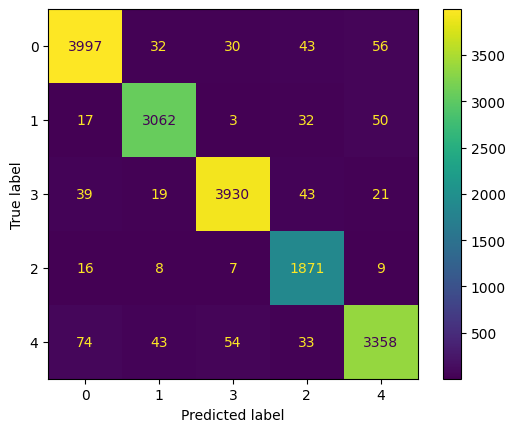

Test results
Accuracy:  0.91
Precision:  0.91
Recall:  0.91
F1 Score:  0.91
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.91      0.93      0.92      1036
           1       0.92      0.89      0.91       798
           2       0.94      0.93      0.93      1050
           3       0.87      0.90      0.88       446
           4       0.89      0.89      0.89       882

    accuracy                           0.91      4212
   macro avg       0.91      0.91      0.91      4212
weighted avg       0.91      0.91      0.91      4212



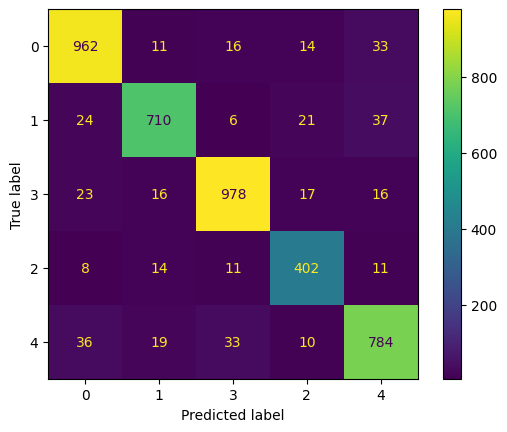

                                                                          Estimator  \
0  LogisticRegression(C=1, class_weight='balanced', random_state=40, solver='saga')   

   Accuracy  Precision  Recall  F1_Score  ROC_AUC_Score  
0      0.91       0.91    0.91      0.91           0.99  


In [162]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],  #['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'saga'], #['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200], #[100, 200, 300, 500, 1000]
    'class_weight': ['balanced']
}
model=run_model(LogisticRegression(random_state=40),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
#SAVE MODEL
pickle.dump(model, open("lr_model.pkl", "wb"))

### 2. Decision Tree

Execution Start Time :  2024-12-11 14:33:14.271496
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



Execution End Time :  2024-12-11 14:40:52.516651
Execution time: 458.24515175819397 seconds
Training results
Accuracy:  0.89
Precision:  0.89
Recall:  0.89
F1 Score:  0.89
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.90      0.90      0.90      4158
           1       0.91      0.91      0.91      3164
           2       0.94      0.90      0.92      4052
           3       0.91      0.84      0.87      1911
           4       0.82      0.89      0.85      3562

    accuracy                           0.89     16847
   macro avg       0.89      0.89      0.89     16847
weighted avg       0.89      0.89      0.89     16847



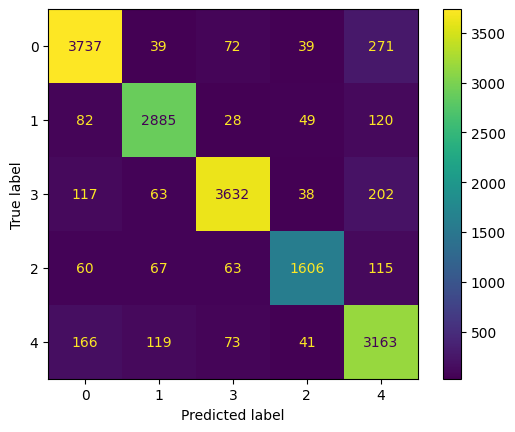

Test results
Accuracy:  0.78
Precision:  0.78
Recall:  0.78
F1 Score:  0.78
ROC AUC Score:  0.89
Classification Report:                precision    recall  f1-score   support

           0       0.79      0.79      0.79      1036
           1       0.79      0.79      0.79       798
           2       0.86      0.83      0.85      1050
           3       0.75      0.71      0.73       446
           4       0.68      0.74      0.71       882

    accuracy                           0.78      4212
   macro avg       0.78      0.77      0.77      4212
weighted avg       0.78      0.78      0.78      4212



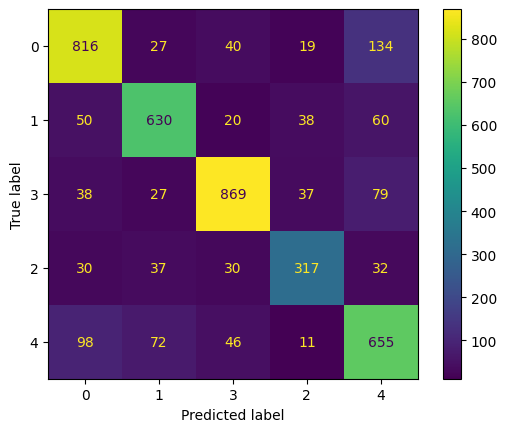

                                                                                                                Estimator  \
0                                        LogisticRegression(C=1, class_weight='balanced', random_state=40, solver='saga')   
1  DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=5,\n                       random_state=40)   

   Accuracy  Precision  Recall  F1_Score  ROC_AUC_Score  
0      0.91       0.91    0.91      0.91           0.99  
1      0.78       0.78    0.78      0.78           0.89  


In [163]:
#running and evaluating the Decision Tree model
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': [None, 'sqrt', 'log2']
}
model=run_model(DecisionTreeClassifier(random_state=40),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
#SAVE MODEL
pickle.dump(model, open("dtree_model.pkl", "wb"))

### 3. Random Forest

Execution Start Time :  2024-12-11 14:40:53.448813
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Execution End Time :  2024-12-11 14:50:53.848677
Execution time: 600.3998618125916 seconds
Training results
Accuracy:  0.9
Precision:  0.91
Recall:  0.9
F1 Score:  0.9
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.85      0.98      0.91      4158
           1       0.95      0.86      0.91      3164
           2       0.89      0.95      0.92      4052
           3       0.96      0.74      0.84      1911
           4       0.93      0.88      0.90      3562

    accuracy                           0.90     16847
   macro avg       0.92      0.88      0.89     16847
weighted avg       0.91      0.90      0.90     16847



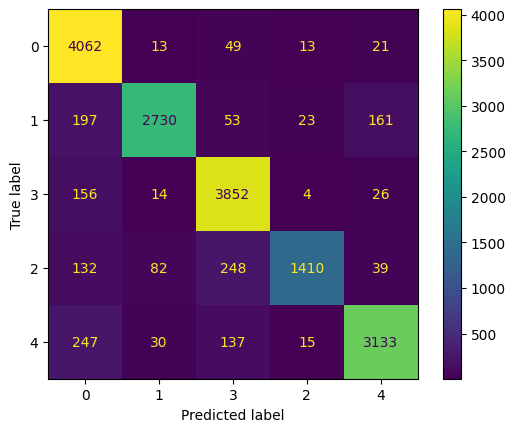

Test results
Accuracy:  0.79
Precision:  0.81
Recall:  0.79
F1 Score:  0.79
ROC AUC Score:  0.96
Classification Report:                precision    recall  f1-score   support

           0       0.72      0.93      0.81      1036
           1       0.82      0.64      0.72       798
           2       0.82      0.90      0.86      1050
           3       0.95      0.59      0.73       446
           4       0.80      0.75      0.78       882

    accuracy                           0.79      4212
   macro avg       0.82      0.76      0.78      4212
weighted avg       0.81      0.79      0.79      4212



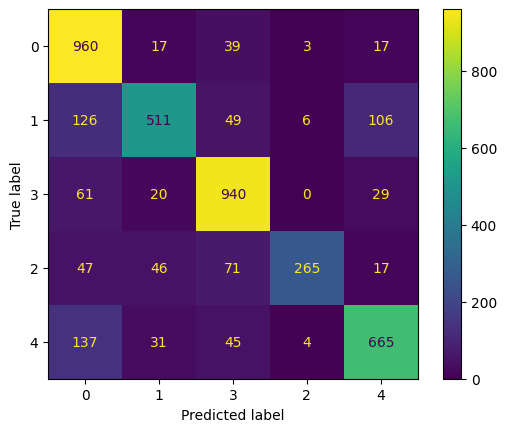

                                                                                                                 Estimator  \
0                                         LogisticRegression(C=1, class_weight='balanced', random_state=40, solver='saga')   
1   DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=5,\n                       random_state=40)   
2  RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,\n                       random_state=40)   

   Accuracy  Precision  Recall  F1_Score  ROC_AUC_Score  
0      0.91       0.91    0.91      0.91           0.99  
1      0.78       0.78    0.78      0.78           0.89  
2      0.79       0.81    0.79      0.79           0.96  


In [164]:
#running and evaluating the Random Forest model
params = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [ None, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'bootstrap': [True]
}
model=run_model(RandomForestClassifier(random_state=40),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
#SAVE MODEL
pickle.dump(model, open("rf_model.pkl", "wb"))

### 4. Multinomial Naive Bayes

Execution Start Time :  2024-12-11 14:50:56.226894
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Execution End Time :  2024-12-11 14:50:57.635917
Execution time: 1.4090220928192139 seconds
Training results
Accuracy:  0.86
Precision:  0.86
Recall:  0.86
F1 Score:  0.86
ROC AUC Score:  0.98
Classification Report:                precision    recall  f1-score   support

           0       0.85      0.91      0.88      4158
           1       0.84      0.79      0.81      3164
           2       0.90      0.88      0.89      4052
           3       0.81      0.85      0.83      1911
           4       0.85      0.83      0.84      3562

    accuracy                           0.86     16847
   macro avg       0.85      0.85      0.85     16847
weighted avg       0.86      0.86      0.86     16847



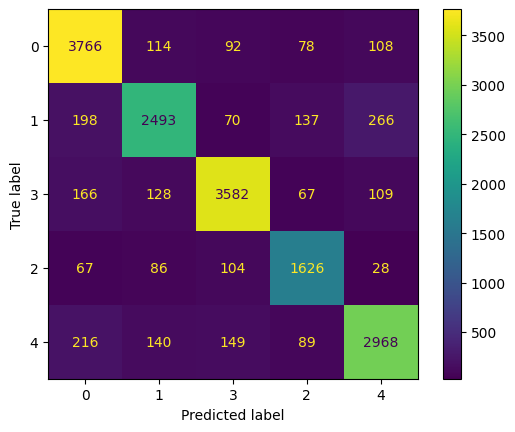

Test results
Accuracy:  0.76
Precision:  0.76
Recall:  0.76
F1 Score:  0.76
ROC AUC Score:  0.94
Classification Report:                precision    recall  f1-score   support

           0       0.76      0.83      0.79      1036
           1       0.70      0.65      0.67       798
           2       0.83      0.82      0.82      1050
           3       0.74      0.71      0.73       446
           4       0.74      0.74      0.74       882

    accuracy                           0.76      4212
   macro avg       0.75      0.75      0.75      4212
weighted avg       0.76      0.76      0.76      4212



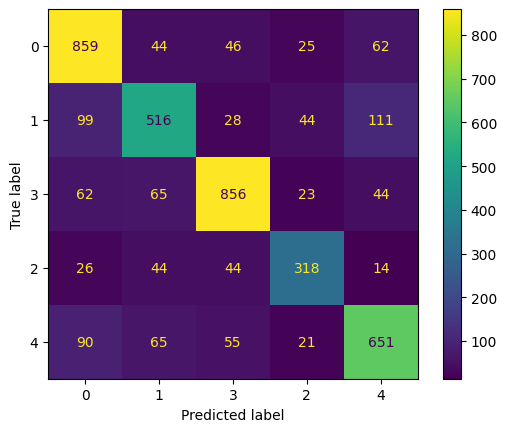

                                                                                                                 Estimator  \
0                                         LogisticRegression(C=1, class_weight='balanced', random_state=40, solver='saga')   
1   DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=5,\n                       random_state=40)   
2  RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,\n                       random_state=40)   
3                                                                                MultinomialNB(alpha=0.1, fit_prior=False)   

   Accuracy  Precision  Recall  F1_Score  ROC_AUC_Score  
0      0.91       0.91    0.91      0.91           0.99  
1      0.78       0.78    0.78      0.78           0.89  
2      0.79       0.81    0.79      0.79           0.96  
3      0.76       0.76    0.76      0.76           0.94  


In [165]:
#running and evaluating the Gaussian Naive Bayes model
params = {
    'alpha': [0.1, 0.5, 1, 2, 5],
    'fit_prior': [True, False]
}
model=run_model(MultinomialNB(),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
#SAVE MODEL
pickle.dump(model, open("nb_model.pkl", "wb"))

### 5. XGBoost Classifier

In [ ]:
#running and evaluating the XGBoost model
params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'gamma': [0, 1]
}
model=run_model(XGBClassifier(random_state=40,n_jobs=-1),params)
model_summary=eval_model(model,model_summary,y_train,model.predict(X_train),model.predict_proba(X_train),type='Training')
model_summary=eval_model(model,model_summary,y_test,model.predict(X_test),model.predict_proba(X_test),type='Test')
# Print Model Summary
print(model_summary)
#SAVE MODEL
pickle.dump(model, open("xgb_model.pkl", "wb"))

Execution Start Time :  2024-12-11 16:06:40.537259
Fitting 5 folds for each of 8 candidates, totalling 40 fits


## Final

In [173]:
pd.set_option('display.max_colwidth', None)
model_summary["Estimator"]

,Estimator
0,"LogisticRegression(C=1, class_weight='balanced', random_state=40, solver='saga')"
1,"DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=5,\n random_state=40)"
2,"RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,\n random_state=40)"
3,"MultinomialNB(alpha=0.1, fit_prior=False)"


In [174]:
# Define source folder
source_folder = '/content'
# Define destination folder
consolidated_folder = f'{folder_path}/files'
# Ensure the destination folder exists
os.makedirs(consolidated_folder, exist_ok=True)
for file_name in os.listdir(source_folder):
    # Check if the file has a .csv or .pkl extension
    if file_name.endswith('.csv') or file_name.endswith('.pkl'):
        source_file = os.path.join(source_folder, file_name)  # Full path of source file
        destination_file = os.path.join(consolidated_folder, file_name)  # Full path of destination file
        # Copy the file to the consolidated folder
        shutil.copy(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")
print("All .csv and .pkl files have been copied.")

Copied /content/rf_model.pkl to /content/drive/My Drive/Ticket_Classification/files/rf_model.pkl
Copied /content/lr_model.pkl to /content/drive/My Drive/Ticket_Classification/files/lr_model.pkl
Copied /content/nb_model.pkl to /content/drive/My Drive/Ticket_Classification/files/nb_model.pkl
Copied /content/df_clean.csv to /content/drive/My Drive/Ticket_Classification/files/df_clean.csv
Copied /content/count_vector.pkl to /content/drive/My Drive/Ticket_Classification/files/count_vector.pkl
Copied /content/dtree_model.pkl to /content/drive/My Drive/Ticket_Classification/files/dtree_model.pkl
Copied /content/tfidf.pkl to /content/drive/My Drive/Ticket_Classification/files/tfidf.pkl
All .csv and .pkl files have been copied.
